# ECON 441B: Week 7 Assignment
Courtney Manhart

# 1.) Import an asset price from Yahoo Finance

In [10]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.metrics import BinaryAccuracy


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("DIS", start="1990-01-01", end="2022-02-21")
  # Picking the Disney Company Ticker 


# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [12]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5 ## number of time Lags -- using the last 5 days to predict the next 
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])

    ## Need to Fix y-train to be going up/down (binary)
      # if y_train > 0 --> 1
      # Elif y_train < 0 --> 0 
    if train_data[i,0] >= 0:
      y_train.append(1)
    elif train_data[i, 0] < 0:
      y_train.append(0)


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, 
               input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))

## Classification: Pick Activation Function 
model.add(Dense(1, activation = 'sigmoid')) # Output layer 
  # Sigmoid will give % that we will need to convert to 0/1



model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
6472/6472 [==============================] - 62s 8ms/step - loss: 0.6933 - accuracy: 0.5170
Epoch 2/3
6472/6472 [==============================] - 52s 8ms/step - loss: 0.6928 - accuracy: 0.5210
Epoch 3/3
6472/6472 [==============================] - 50s 8ms/step - loss: 0.6926 - accuracy: 0.5219


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [13]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test_data = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
y_test = []
for i in range(len(y_test_data)):
  if y_test_data[i] >= 0:
    y_test.append(1)
  elif y_test_data[i] < 0:
    y_test.append(0)


for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))



predictions = model.predict(x_test)



51/51 [==============================] - 1s 4ms/step


In [14]:
## IN sample Random Walk Model
actual_train = y_train[1:] #Actual
pred_train = y_train[:-1] #predicted

num = 0
for i in range(len(actual_train)):
  if actual_train[i] == pred_train[i]:
    num += 1

in_RW_auc = num / len(actual_train)

print('In Sample Random Walk Auccuracy:', in_RW_auc)

# OOS Random Walk Model
actual_test = y_test[1:] #Actual
pred_test = y_test[:-1] #predicted

num = 0
for i in range(len(actual_test)):
  if actual_test[i] == pred_test[i]:
    num += 1

out_RW_auc = num / len(actual_test)
print('Out of Sample Random Walk Auccuracy:', out_RW_auc)


In Sample Random Walk Auccuracy: 0.49528666357595424
Out of Sample Random Walk Auccuracy: 0.4793082149474985


In [15]:
## In Sample Model Accuracy
y_predictions = model.predict(x_train) 
num = 0
for i in range(len(y_predictions)):
  if y_predictions[i] >= 0.5 and y_train[i] == 1:
    num += 1
  elif y_predictions[i] < 0.5 and y_train[i] == 0:
    num += 1
in_mod_auc = num/ len(y_train)

print('In Sample Model Accuracy:', in_mod_auc)


## OOS Model Accuracy
num = 0
for i in range(len(predictions)):
  if predictions[i] >= 0.5 and y_test[i] == 1:
    num += 1
  elif predictions[i] < 0.5 and y_test[i] == 0:
    num += 1
out_mod_auc = num/ len(y_test)

print('Out Sample Model Accuracy:', out_mod_auc)

203/203 [==============================] - 1s 4ms/step
In Sample Model Accuracy: 0.5227132262051916
Out Sample Model Accuracy: 0.5049382716049383


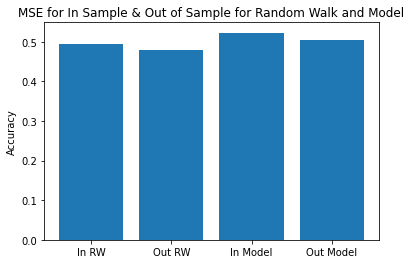

In [16]:
## Creating Bar Chart

import matplotlib.pyplot as plt

plt.bar(['In RW', 'Out RW', 'In Model', 'Out Model'],
        height = [in_RW_auc, out_RW_auc, in_mod_auc, out_mod_auc], width = 0.8)
plt.ylabel('Accuracy')
plt.title("MSE for In Sample & Out of Sample for Random Walk and Model")
plt.show()

# 4.) Plot in and out of sample accuracy --- DO NOT NEED TO DO


In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

Based on our observations from the graph in Q3, our model has a smaller MSE for both the in-sample and out of sample. 

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [18]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model(numInputs): ## Add a Parameter that will change # of inputs (structure of Q1 needs to be in here)
  input_size = numInputs ## number of time Lags -- using the last 5 days to predict the next 
  x_train = []
  y_train = []
  for i in range(input_size, len(train_data)):
      x_train.append(train_data[i-input_size:i, 0])

      ## Need to Fix y-train to be going up/down (binary)
        # if y_train > 0 --> 1
        # Elif y_train < 0 --> 0 
      if train_data[i,0] >= 0:
        y_train.append(1)
      elif train_data[i, 0] < 0:
        y_train.append(0)


  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


  model = Sequential()
  model.add(LSTM(x_train.shape[1], return_sequences=True, 
                input_shape=(x_train.shape[1], 1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(25))

  ## Classification: Pick Activation Function 
  model.add(Dense(1, activation = 'sigmoid')) # Output layer 
    # Sigmoid will give % that we will need to convert to 0/1


  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
param_grid = {'numInputs': [5, 10, 20]}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_data, train_data)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-18-fd42873be6c8>:42: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.000000 using {'numInputs': 5}
